# 不動産時系列データにカルマンフィルタを適用する

In [1]:
import sys
sys.path.append('/Users/LOng/sengokulab/LDAT_LS_2019/scripts/')

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import calc_variogram as variogram
import kriging_est as kriging
import kalmanfilter as kalman

In [3]:
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/peseudo_monthly_rent_data.csv')

In [4]:
data.head()

,No,都道府県,市区町村,町丁目,築年,築月,構造,マンション最上階数,間取別平均平米単価①,間取別平均平米単価②,...,最寄駅経度,始点ノード,終点ノード,最寄駅までの距離,month,月別間取別平均平米単価①,月別間取別平均平米単価②,月別間取別平均平米単価③,月別間取別平均平米単価④,月別間取別平均平米単価⑤
0,1,東京都,世田谷区,喜多見７丁目,1988,3,ＲＣ,2,2812.2742,2311.9321,...,139.587513,1.395870e+14,1.395930e+14,1096.93,9,2868.519684,2358.170742,2273.304804,2188.708860,2687.040060
1,2,東京都,世田谷区,喜多見７丁目,2005,3,鉄骨造,3,3006.8074,2633.6113,...,139.587513,1.395870e+14,1.395920e+14,930.57,3,3217.283918,2817.964091,2654.611792,2753.539712,2925.088746
2,3,東京都,世田谷区,喜多見９丁目,2001,4,ＲＣ,3,2828.1343,2675.7913,...,139.587513,1.395870e+14,1.395860e+14,457.66,6,2941.259672,2782.822952,2617.707040,2496.012480,2934.125168
3,4,東京都,世田谷区,喜多見９丁目,1991,9,ＲＣ,3,2787.3645,2428.8105,...,139.587513,1.395870e+14,1.395850e+14,567.25,9,2843.111790,2477.386710,2427.445878,2354.673774,2804.593836
4,5,東京都,世田谷区,喜多見９丁目,1987,3,ＡＬＣ,2,2665.9316,2389.2583,...,139.587513,1.395870e+14,1.395860e+14,630.01,7,2719.250232,2437.043466,2419.430310,2332.399626,2529.010848


In [5]:
len(data)

3852

In [6]:
data.columns = ['No', '都道府県', '市区町村', '町丁目', 'year', '築月', '構造', 'マンション最上階数',
       '間取別平均平米単価①', '間取別平均平米単価②', '間取別平均平米単価③', '間取別平均平米単価④',
       '間取別平均平米単価⑤', '物件緯度', '物件経度', '最寄駅', '最寄駅緯度', '最寄駅経度', '始点ノード',
       '終点ノード', '最寄駅までの距離', 'month', '月別間取別平均平米単価①', '月別間取別平均平米単価②',
       '月別間取別平均平米単価③', '月別間取別平均平米単価④', '月別間取別平均平米単価⑤']

In [7]:
data.columns.values

array(['No', '都道府県', '市区町村', '町丁目', 'year', '築月', '構造', 'マンション最上階数',
       '間取別平均平米単価①', '間取別平均平米単価②', '間取別平均平米単価③', '間取別平均平米単価④',
       '間取別平均平米単価⑤', '物件緯度', '物件経度', '最寄駅', '最寄駅緯度', '最寄駅経度', '始点ノード',
       '終点ノード', '最寄駅までの距離', 'month', '月別間取別平均平米単価①', '月別間取別平均平米単価②',
       '月別間取別平均平米単価③', '月別間取別平均平米単価④', '月別間取別平均平米単価⑤'], dtype=object)

## 時系列データの作成
- 分散一定の減少トレンドを描く。月-10円すると考える
- 季節性のサイクルを描く。１月から始まって12月まで。1年間
    - 1: 1.00, 2: 1.02, 3: 1.07, 4: 1.06, 5: 1.06, 6: 1.04, 7: 1.02, 8: 1.00, 9: 1.02, 10: 1.05, 11: 1.04, 12: 1.04

In [474]:
np.random.seed(1)

In [475]:
trend = 50*np.random.randn(12, 3852) - 10

In [476]:
trend.T[0]

array([ 71.21726818, -59.69905605, -60.70178294,  37.26361946,
       -40.87517201,  18.3786943 ,  66.28950513,  17.25604885,
       -18.38170899, -58.14349662,  88.64279309, -79.82871272])

In [477]:
tes = np.array([np.sum(trend.T[0][:i]) for i in range(1, 13)])

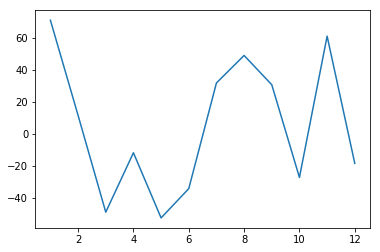

In [478]:
plt.plot(np.linspace(1, 12, 12), tes)

In [479]:
pre_name = "間取別平均平米単価①"
for i in range(0, 12):
    col_name = "price_{}".format(str(i+1))
    data[col_name] = data[pre_name] + trend.T[:, :i].sum(axis=1)
    '''if i == 1:
        data[col_name] += 2*unit
    if i == 2:
        data[col_name] += 7*unit
    if i == 3:
        data[col_name] = 6*unit
    if i == 4:
        data[col_name] += 6*unit
    if i == 5:
        data[col_name] += 4*unit
    if i == 6:
        data[col_name] += 2*unit
    if i == 8:
        data[col_name] += 2*unit
    pre_name = col_name
    '''

In [480]:
tes = data.iloc[0:1, -12:].values

In [481]:
tes[0]

array([2812.2742    , 2883.49146818, 2823.79241214, 2763.0906292 ,
       2800.35424866, 2759.47907665, 2777.85777095, 2844.14727609,
       2861.40332494, 2843.02161595, 2784.87811933, 2873.52091242])

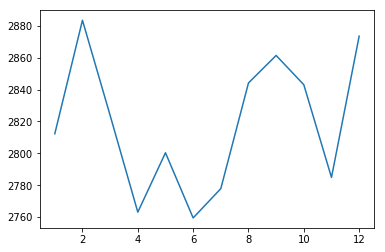

In [482]:
plt.plot(np.linspace(1, 12, 12), tes[0])

In [483]:
np.random.seed(0)
indices = np.random.randint(0, 3852, 200)

In [484]:
dat = data[data.No.isin(indices)]

# 時空間krigingの実装例
- 一時点krigingによる空間相関の推定
- kalmanfilter関数による時系列krigingの実施

## Krigingによる空間相関(分散共分散行列)の推定

In [485]:
Y = np.log(dat.iloc[:, -12:].values)

In [486]:
Y.shape # 196地点, 12ヶ月分のデータ

(196, 12)

In [487]:
dum = pd.get_dummies(dat.町丁目, drop_first=True)
dum2 = pd.get_dummies(dat.構造, drop_first=True)

In [488]:
X1 = dat[['マンション最上階数', '最寄駅までの距離', 'year']]
# X1 = X1.join(dum).join(dum2).values

In [489]:
x = kriging.sm.add_constant(X1).values

In [490]:
x_reg = kriging.sm.add_constant(X1).values

In [491]:
y1 = Y[:, 0:1]

In [492]:
resid = pd.DataFrame(kriging.sm.OLS(y1, x).fit().resid)

In [493]:
mod = kriging.sm.OLS(y1, x).fit()
params = mod.params.T

In [494]:
coords = dat[['物件経度', '物件緯度']].reset_index(drop=True)

In [495]:
resid = coords.join(resid).values

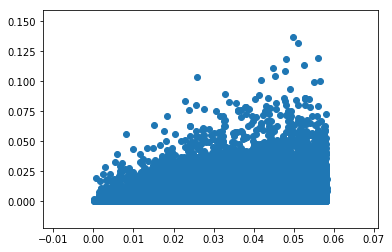

In [496]:
vario = variogram.get_diff(resid)
plt.scatter(vario[0], vario[1])

In [497]:
variogram.emp_variogram(vario, 11)

(array([[0.00270378, 0.00534346, 0.00798314, 0.01062282, 0.0132625 ,
         0.01590219, 0.01854187, 0.02118155, 0.02382123, 0.02646091,
         0.02910059],
        [0.00124512, 0.00193519, 0.00223686, 0.00286301, 0.00354152,
         0.00373245, 0.00436615, 0.0047026 , 0.00493014, 0.00608437,
         0.00632488]]),
 array([ 337.,  785., 1157., 1395., 1514., 1656., 1731., 1731., 1607.,
        1575., 1414.]))

[0.         0.00355674 0.00711348 0.01067022 0.01422696 0.0177837
 0.02134043 0.02489717 0.02845391 0.03201065]
0.01050129786242792 0.033471740430757665


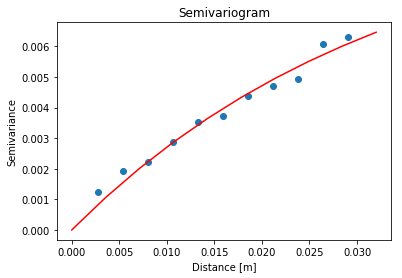

In [498]:
param, lag, fig = variogram.auto_vario(vario, 11, 2)

In [499]:
distance_mat = kriging.calc_distance_matrix(coords, ['物件経度', '物件緯度'])
efrange, c0 = kriging.calc_c0(param, distance_mat)

In [500]:
print(c0)

0.0005228288346280024


In [501]:
covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)

0.0100402332173935


## 時空間krigingの実装 

In [502]:
# Settings
nt = 12
n = 196
SigP = np.identity(n+4) # 状態変数のpriorの分散
SigX = np.identity(n+4) # 状態方程式の攪乱項の分散
SigY = np.identity(n) # 観測方程式の攪乱項の分散
F = np.identity(n)
F = np.hstack([F, x_reg]) # 状態変数と観測値の関係式. Local level + Regression

In [503]:
params = params.reshape(4, 1)

In [504]:
y_pred_list = []
state_est_list = []
for t in range(2, nt+1):
    y = Y[:, t-1].reshape(n, 1)
    if t == 2:
        x = np.vstack([resid[:, 2:], params])
        SigP[0:n, 0:n] = covariance_mat # 状態変数に空間相関を想定
    else:
        x = x1
        SigP = SigP1
        F[:, -1:] = F[:, -1:] - 1
    pred, x1, SigP1, logz, a \
        = kalman.kalman(y, x, SigP, SigX, SigY, F)
    y_pred_list.append(pred)
    state_est_list.append(x1[0:n, 0:n])

In [505]:
# 地点10の結果を確認
j = 10
y_at10 = Y[j-1, :]
y_pred_at10 = [preds[j-1] for preds in y_pred_list]

In [506]:
index = np.linspace(1, 12, 12)

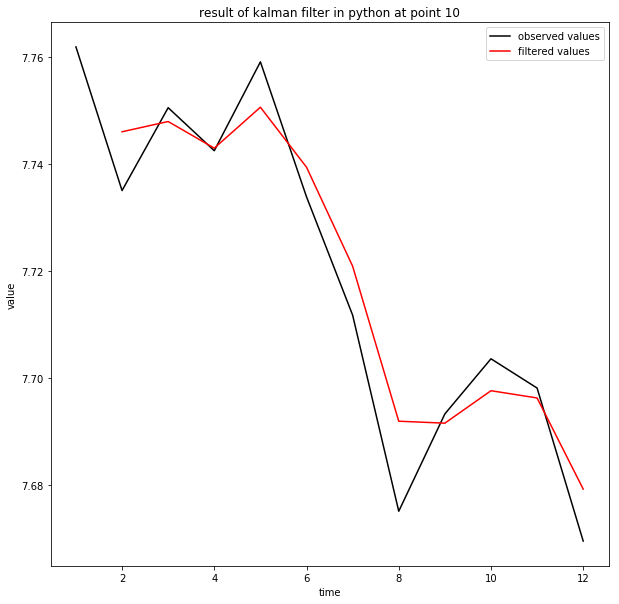

In [507]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(index, y_at10, color='black', label='observed values')
ax.plot(index[1:], y_pred_at10, color='red', label='filtered values')
ax.set_title('result of kalman filter in python at point 10')
ax.set_xlabel('time')
ax.set_ylabel('value')
ax.legend()

In [508]:
fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/res_sptemp_kriging.png')

In [317]:
state_at10 = [preds[j-1] for preds in state_est_list]

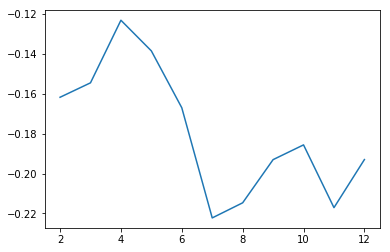

In [318]:
plt.plot(index[1:], state_at10)